# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [27]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [28]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX_API_KEY")
px.set_mapbox_access_token(mapbox_token)
type(mapbox_token)

str

# Import Data

In [29]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)


- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [30]:
# Define Panel Visualization Functions
def housing_units_per_year():
    housing_units_per_year = sfo_data["housing_units"].groupby("year").mean()  
    fig_house_units = plt.figure()
    plot_house_units = housing_units_per_year.plot.bar()
    plot_house_units.set_xlabel("Year")
    plot_house_units.set_ylabel("Housing Units")
    plot_house_units.set_title(
        "Housing Units in San Francisco from 2010 to 2016", 
        fontsize=13, weight="bold"
)
    max_house = max(housing_units_per_year)
    min_house = min(housing_units_per_year)
    plot_house_units.set_ylim(min_house, max_house)
    plt.close(fig_house_units)
    return pn.pane.Matplotlib(fig_house_units)  

def average_gross_rent():
    avg_gross_rent = sfo_data["gross_rent"].groupby("year").mean()
    fig_gross_rent = plt.figure()   
    plot_gross_rent = avg_gross_rent.plot.line()
    plot_gross_rent.set_xlabel("Year")
    plot_gross_rent.set_ylabel("Gross Rent")
    plot_gross_rent.set_title(
        "Average Gross Rent in San Francisco from 2010 - 2016",
        fontsize=13, weight="bold"
)
    plt.close(fig_gross_rent)
    return pn.pane.Matplotlib(fig_gross_rent)

def average_sales_price():
    average_sales_price = sfo_data["sale_price_sqr_foot"].groupby("year").mean()
    fig_sales_price = plt.figure()
    plot_sales_price = average_sales_price.plot.line()
    plot_sales_price.set_xlabel("Year")
    plot_sales_price.set_ylabel("Avg. Sale Price")
    plot_sales_price.set_title(
        "Avg Sale Price per Square Foot in San Francisco: 2010 - 2016", 
        fontsize=12, weight="bold"
)
    plt.close(fig_sales_price)
    return pn.pane.Matplotlib(fig_sales_price)

mean_price = (
    sfo_data[["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"]]
    .groupby("neighborhood")
    .mean()
    .sort_values("sale_price_sqr_foot", axis = 0, ascending = False).reset_index()
)
mean_price

def average_price_by_neighborhood():
    average_price_by_neighborhood = sfo_data.groupby(
        ["year", "neighborhood"]).mean().reset_index()
    average_price_by_neighborhood = average_price_by_neighborhood.hvplot.line(
    x="year", y="sale_price_sqr_foot",
    title="Avg. Sale Price per Square Foot from 2010 - 2016", width=600, height=300,
    groupby="neighborhood", 
        xlabel="Year", 
        ylabel="Avg. Sale Price per Square Foot",
    ylim=(180, 610), widget_location="top_right"
)
    return average_price_by_neighborhood

def top_most_expensive_neighborhoods():
    top_most_expensive_neighborhoods = mean_price.head(10).hvplot.bar(
    x="neighborhood", rot=90, y="sale_price_sqr_foot",
    title="Top 10 Expensive Neighborhoods in SFO", 
    xlabel="Neighborhood", ylabel="Avg. Sale Price per Square Foot from 2010 - 2016",
    height=400, width=600
)
    return top_most_expensive_neighborhoods


def parallel_coordinates():
    neighborhood_coordinates = px.parallel_coordinates(
    mean_price.head(10),
    dimensions=["sale_price_sqr_foot", "housing_units", "gross_rent"],   
    color="sale_price_sqr_foot",
    color_continuous_scale=px.colors.sequential.Inferno,
    labels={
        "housing_type": "Housing Type",
        "sale_price_sqr_foot": "Sale Price per Square Foot",
        "housing_units": "Housing Units",
        "gross_rent": "Gross Rent"
    }  
)
    return neighborhood_coordinates

def parallel_categories():
    neighborhood_categories = px.parallel_categories(
    mean_price.head(10),
    dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],   
    color="sale_price_sqr_foot",
    color_continuous_scale=px.colors.sequential.Inferno,
    labels={
        "housing_type": "Housing Type",
        "sale_price_sqr_foot": "Sale Price per Square Foot",
        "housing_units": "Housing Units",
        "gross_rent": "Gross Rent"
    }
)
    return neighborhood_categories

sfo_data_new = sfo_data.rename(columns={"neighborhood": "Neighborhood"})
mean_value = (
    sfo_data_new[["Neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"]]
    .groupby("Neighborhood")
    .mean().reset_index()
)
mean_value

def neighborhood_map():
    neighborhood_join = pd.merge(df_neighborhood_locations, mean_value, on=["Neighborhood"])
    neighborhood_map = px.scatter_mapbox(
    neighborhood_join,
    title="Neighborhoods - average price per square foot and gross rents",
    lat="Lat",
    lon="Lon", 
    size="sale_price_sqr_foot",
    color="gross_rent",
    zoom=11,
    hover_name="Neighborhood"
)
    return neighborhood_map


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [49]:
row_1 = pn.Row(
    neighborhood_map()),
row_2 = pn.Row(
    housing_units_per_year(), average_gross_rent(), average_sales_price()),
row_3 = pn.Row(
    average_price_by_neighborhood(), top_most_expensive_neighborhoods()),
row_4 = pn.Row(
    parallel_coordinates(), parallel_categories())

column = pn.Column(
    "##San Francisco Housing Analysis from 2010 - 2016",
    housing_units_per_year(),
    average_gross_rent(),
    average_sales_price(),
    average_price_by_neighborhood(), 
    top_most_expensive_neighborhoods(),
    neighborhood_map(),
    parallel_coordinates(),
    parallel_categories()
)

title = pn.pane.Markdown(
    " #San Francisco Housing Analysis",
    background="#969696", 
    width=450, 
    height=50
)

sf_dashboard = pn.Tabs(
    ("All Plots", column),
    ("Housing Units", housing_units_per_year),
    ("Avg Rent", average_gross_rent),
    ("Avg Price", average_sales_price),
    ("Avg by Neighborhood", average_price_by_neighborhood),
    ("Top 10 Neighborhoods", top_most_expensive_neighborhoods),
    ("Neighborhood", neighborhood_map),
    ("Parallel 1", parallel_coordinates), 
    ("Parallel 2", parallel_categories),
    dynamic=True
)
sf_dashboard_final = pn.Column(title, sf_dashboard)

## Serve the Panel Dashboard

Column
    [0] Markdown(str, background='#969696', height=50, sizing_mode='fixed', width=450)
    [1] Tabs(dynamic=True)
        [0] Column
            [0] Markdown(str)
            [1] Matplotlib(Figure)
            [2] Matplotlib(Figure)
            [3] Matplotlib(Figure)
            [4] Column
                [0] Row
                    [0] HSpacer()
                    [1] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] HoloViews(DynamicMap, widget_location='top_right')
            [5] HoloViews(Bars)
            [6] Plotly(Figure)
            [7] Plotly(Figure)
            [8] Plotly(Figure)
        [1] Column
            [0] Column()
            [1] Row
                [0] Matplotlib(Figure)
        [2] Column
            [0] Column()
            [1] Row
                [0] Matplotlib(Figure)
        [3] Column
            [0] Column()
            [1] Row
                [0] Matplotlib(Figure)
        [4] Column
            [0] Column()
            [1] Row
                [0] Column
                    [0] Row
                        [0] HSpacer()
                        [1] WidgetBox
                            [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] HoloViews(DynamicMap, widget_location='top_right')
        [5] Column
            [0] Column()
            [1] Row
                [0] HoloViews(Bars, name='interactive09154')
        [6] Column
            [0] Column()
            [1] Row
                [0] Plotly(Figure, name='interactive09239')
        [7] Column
            [0] Column()
            [1] Row
                [0] Plotly(Figure, name='interactive09245')
        [8] Column
            [0] Column()
            [1] Row
                [0] Plotly(Figure, name='interactive09251')
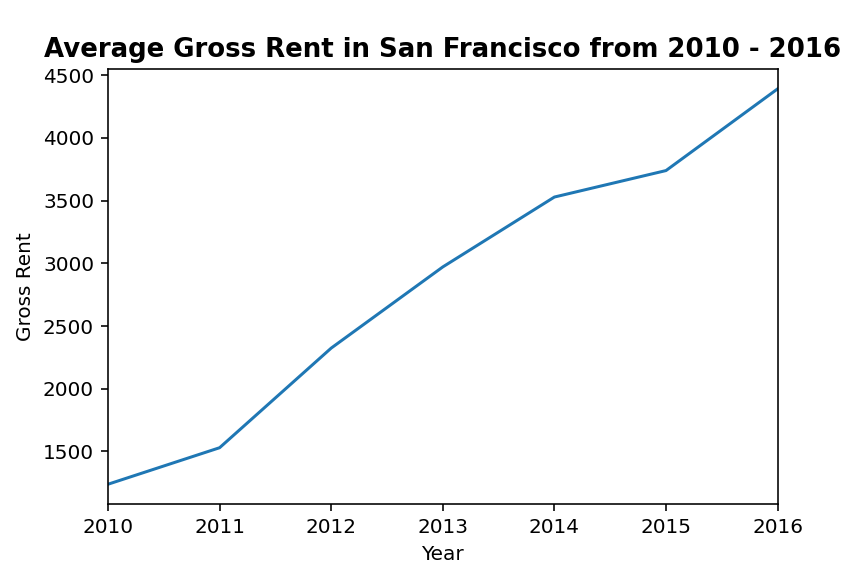
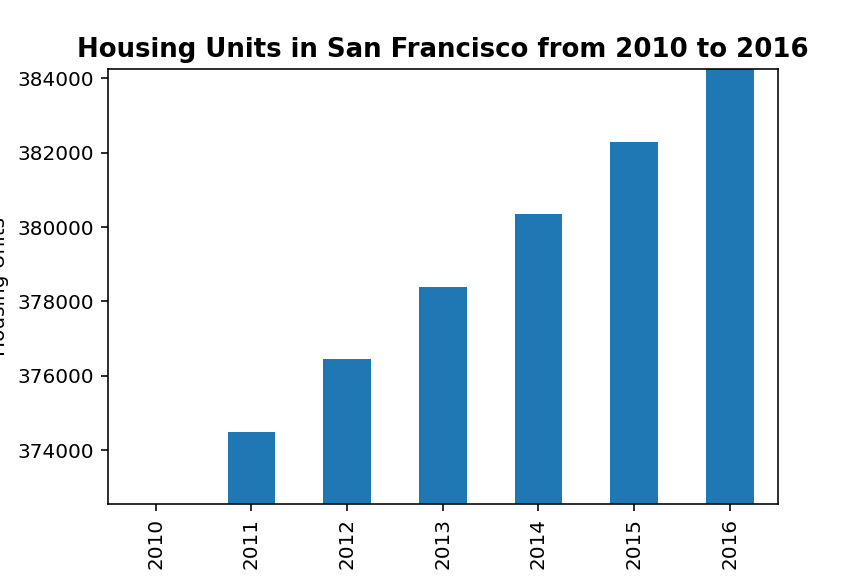
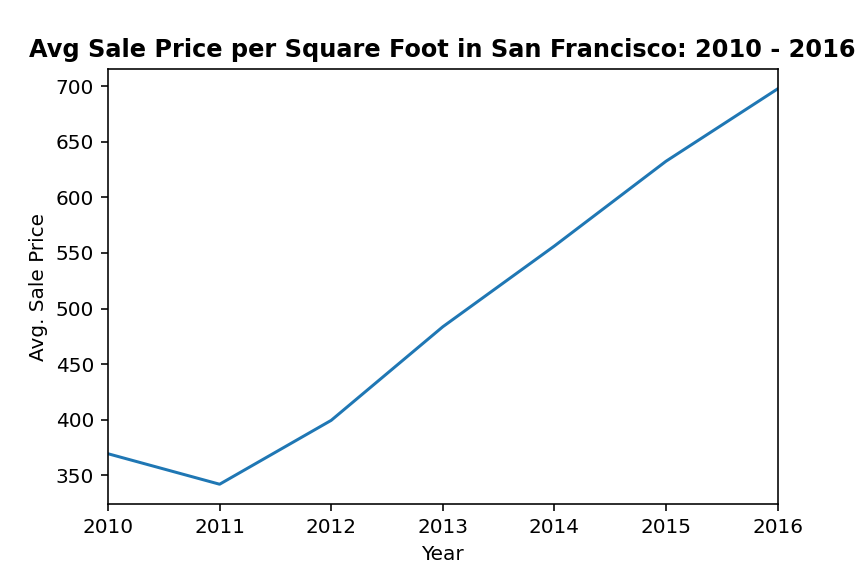

In [50]:
sf_dashboard_final.servable()